In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as data
import yfinance as yf

In [20]:
start = '2020-01-01'
end = '2024-03-11'

# Get the data
df = yf.download('AAPL', start=start, end=end)
df = df[['Open', 'High', 'Low', 'Close']]
df.reset_index(inplace=True)
df.set_index('Date', inplace=True)
print(df.head())

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close
Date                                                  
2020-01-02  74.059998  75.150002  73.797501  75.087502
2020-01-03  74.287498  75.144997  74.125000  74.357498
2020-01-06  73.447502  74.989998  73.187500  74.949997
2020-01-07  74.959999  75.224998  74.370003  74.597504
2020-01-08  74.290001  76.110001  74.290001  75.797501


In [9]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-03-04,176.149994,176.899994,173.789993,175.100006,175.100006,81510100
2024-03-05,170.759995,172.039993,169.619995,170.119995,170.119995,95132400
2024-03-06,171.059998,171.240005,168.679993,169.119995,169.119995,68587700
2024-03-07,169.149994,170.729996,168.490005,169.000000,169.000000,71765100
2024-03-08,169.000000,173.699997,168.940002,170.729996,170.729996,76114600


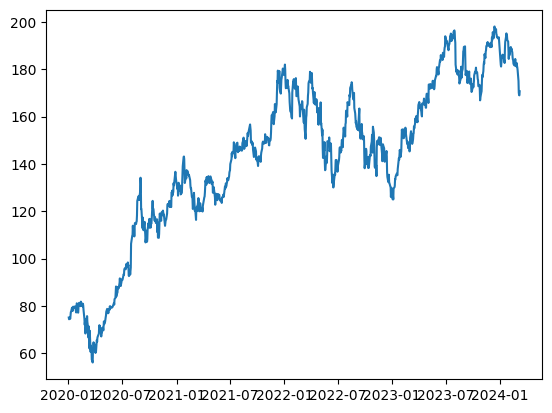

In [21]:
plt.plot(df.Close)

In [22]:
df

,Open,High,Low,Close
Date,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502
2020-01-03,74.287498,75.144997,74.125000,74.357498
2020-01-06,73.447502,74.989998,73.187500,74.949997
2020-01-07,74.959999,75.224998,74.370003,74.597504
2020-01-08,74.290001,76.110001,74.290001,75.797501
...,...,...,...,...
2024-03-04,176.149994,176.899994,173.789993,175.100006
2024-03-05,170.759995,172.039993,169.619995,170.119995
2024-03-06,171.059998,171.240005,168.679993,169.119995


In [24]:
ma100 = df.Close.rolling(100).mean()
ma100

Date
2020-01-02         NaN
2020-01-03         NaN
2020-01-06         NaN
2020-01-07         NaN
2020-01-08         NaN
                ...   
2024-03-04    185.7363
2024-03-05    185.6536
2024-03-06    185.5468
2024-03-07    185.4297
2024-03-08    185.3485
Name: Close, Length: 1053, dtype: float64

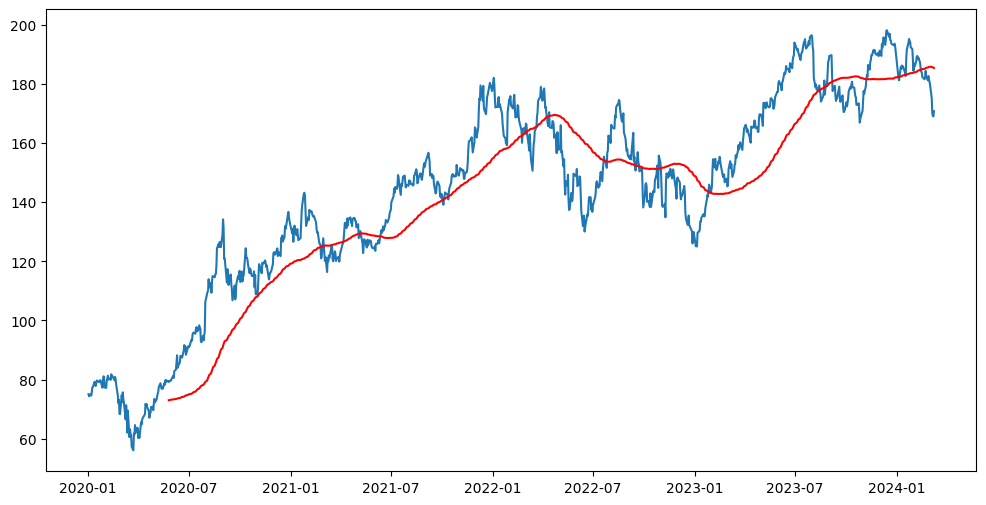

In [25]:
plt.figure(figsize=(12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')

In [26]:
ma200 = df.Close.rolling(200).mean()
ma200

Date
2020-01-02          NaN
2020-01-03          NaN
2020-01-06          NaN
2020-01-07          NaN
2020-01-08          NaN
                ...    
2024-03-04    183.95730
2024-03-05    183.94445
2024-03-06    183.91480
2024-03-07    183.88400
2024-03-08    183.86665
Name: Close, Length: 1053, dtype: float64

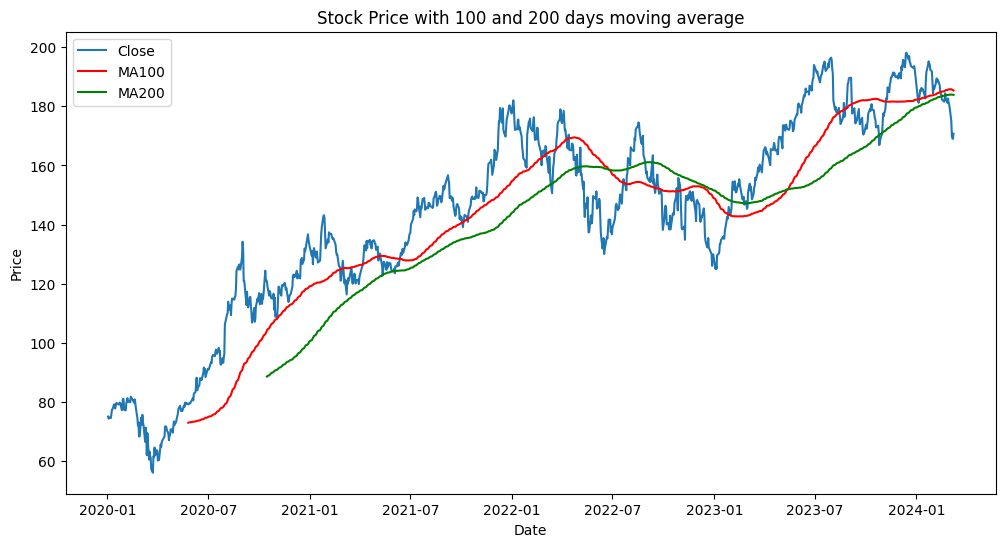

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')
plt.legend(['Close', 'MA100', 'MA200'])
plt.title('Stock Price with 100 and 200 days moving average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [28]:
df.shape

(1053, 6)

In [29]:
# splitting the data into training and test set

data_training = pd.DataFrame(df['Close'][0:int(len(df)*0.70)])
data_testing = pd.DataFrame(df['Close'][int(len(df)*0.70):int(len(df))])

print(data_training.shape)
print(data_testing.shape)

(737, 1)
(316, 1)


In [30]:
data_training.head()

,Close
Date,
2020-01-02,75.087502
2020-01-03,74.357498
2020-01-06,74.949997
2020-01-07,74.597504
2020-01-08,75.797501


In [31]:
data_testing.head()

,Close
Date,
2022-12-05,146.630005
2022-12-06,142.910004
2022-12-07,140.940002
2022-12-08,142.649994
2022-12-09,142.160004


In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [33]:
data_training_array = scaler.fit_transform(data_training)
data_training_array

array([[0.15085277],
       [0.14505529],
       [0.14976075],
       [0.14696135],
       [0.15649137],
       [0.16927753],
       [0.17066729],
       [0.18383068],
       [0.17533306],
       [0.17267259],
       [0.18041574],
       [0.18734493],
       [0.1830564 ],
       [0.18529994],
       [0.18833764],
       [0.18651102],
       [0.16792745],
       [0.18528007],
       [0.19848314],
       [0.19754999],
       [0.16903929],
       [0.16735166],
       [0.18758317],
       [0.19274529],
       [0.20021045],
       [0.18992596],
       [0.19294378],
       [0.18909205],
       [0.2041615 ],
       [0.19953542],
       [0.19969428],
       [0.18788097],
       [0.19705363],
       [0.190462  ],
       [0.17606765],
       [0.14654436],
       [0.12649154],
       [0.13556496],
       [0.09758373],
       [0.09726605],
       [0.14779519],
       [0.12895351],
       [0.15559791],
       [0.13610106],
       [0.12837772],
       [0.08299089],
       [0.12105149],
       [0.101

In [34]:
x_train = []
y_train = []

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100:i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [35]:
#ML model

from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [41]:
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1))) 
model.add(Dropout(0.2))

model.add(LSTM(units=60, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1))) 
model.add(Dropout(0.3))

model.add(LSTM(units=80, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1))) 
model.add(Dropout(0.4))

model.add(LSTM(units=120, activation='relu')) 
model.add(Dropout(0.5))

model.add(Dense(units=1))

In [44]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout_4 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_7 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_5 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_8 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_6 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_9 (LSTM)               (None, 120)              

In [45]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs = 50) #Train the model using the training data

Epoch 1/50
20/20 [==============================] - 8s 141ms/step - loss: 0.1972
Epoch 2/50
20/20 [==============================] - 3s 142ms/step - loss: 0.0509
Epoch 3/50
20/20 [==============================] - 3s 142ms/step - loss: 0.0236
Epoch 4/50
20/20 [==============================] - 3s 142ms/step - loss: 0.0211
Epoch 5/50
20/20 [==============================] - 3s 142ms/step - loss: 0.0180
Epoch 6/50
20/20 [==============================] - 3s 142ms/step - loss: 0.0180
Epoch 7/50
20/20 [==============================] - 3s 144ms/step - loss: 0.0155
Epoch 8/50
20/20 [==============================] - 3s 144ms/step - loss: 0.0148
Epoch 9/50
20/20 [==============================] - 3s 141ms/step - loss: 0.0147
Epoch 10/50
20/20 [==============================] - 3s 142ms/step - loss: 0.0143
Epoch 11/50
20/20 [==============================] - 3s 141ms/step - loss: 0.0131
Epoch 12/50
20/20 [==============================] - 3s 141ms/step - loss: 0.0123
Epoch 13/50
20/20 [======

In [46]:
model.save('keras_model.h5')

C:\Users\Aditya\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [47]:
data_testing.head()

,Close
Date,
2022-12-05,146.630005
2022-12-06,142.910004
2022-12-07,140.940002
2022-12-08,142.649994
2022-12-09,142.160004


In [48]:
past_100_days = data_training.tail(100)

In [49]:
final_df = past_100_days.append(data_testing, ignore_index=True)

C:\Users\Aditya\AppData\Local\Temp\ipykernel_15636\531349220.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = past_100_days.append(data_testing, ignore_index=True)


In [50]:
final_df.head()

,Close
0,148.470001
1,150.169998
2,147.070007
3,151.000000
4,153.039993


In [51]:
input_data = scaler.fit_transform(final_df)
input_data

array([[3.20837369e-01],
       [3.44096322e-01],
       [3.01682987e-01],
       [3.55452209e-01],
       [3.83362910e-01],
       [4.14967955e-01],
       [3.97728802e-01],
       [3.82131602e-01],
       [3.63661349e-01],
       [4.34669516e-01],
       [4.42331478e-01],
       [5.12929208e-01],
       [4.99247447e-01],
       [4.78724805e-01],
       [5.62457327e-01],
       [5.58079063e-01],
       [5.51785569e-01],
       [5.45218174e-01],
       [5.45902303e-01],
       [6.05007613e-01],
       [5.94746292e-01],
       [6.44137459e-01],
       [6.59050529e-01],
       [6.56861397e-01],
       [6.77657733e-01],
       [6.72184903e-01],
       [6.36202013e-01],
       [5.82159097e-01],
       [5.77507139e-01],
       [5.81611709e-01],
       [6.15816113e-01],
       [5.28115972e-01],
       [4.97468960e-01],
       [4.63674992e-01],
       [4.40552782e-01],
       [4.50677361e-01],
       [4.21261448e-01],
       [4.03748810e-01],
       [4.23313838e-01],
       [4.02791195e-01],


In [52]:
input_data.shape

(416, 1)

In [53]:
x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100:i])
    y_test.append(input_data[i, 0])

In [54]:
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(316, 100, 1)
(316,)


In [55]:
#making predictions
y_pred = model.predict(x_test)

10/10 [==============================] - 1s 48ms/step


In [56]:
y_pred.shape

(316, 1)

In [57]:
y_test

array([2.95662978e-01, 2.44766809e-01, 2.17813722e-01, 2.41209417e-01,
       2.34505488e-01, 2.66384017e-01, 2.79792085e-01, 2.48871379e-01,
       1.57066668e-01, 1.29839887e-01, 1.00560926e-01, 9.96033112e-02,
       1.42700776e-01, 9.86454877e-02, 9.35833027e-02, 6.85456542e-02,
       1.39554552e-02, 6.27993394e-02, 6.71773945e-02, 6.84129827e-04,
       1.83336146e-02, 0.00000000e+00, 6.29360819e-02, 7.01873988e-02,
       7.81228455e-02, 1.15884641e-01, 1.14790075e-01, 1.33260327e-01,
       1.49404915e-01, 1.39417287e-01, 1.40238159e-01, 1.75810614e-01,
       2.20139596e-01, 2.39567673e-01, 2.30400917e-01, 2.59132700e-01,
       2.86085578e-01, 2.45998117e-01, 2.63647498e-01, 2.79244697e-01,
       3.52989592e-01, 4.03338374e-01, 3.65439836e-01, 4.05390555e-01,
       3.68039404e-01, 3.53673513e-01, 3.55588951e-01, 3.94445313e-01,
       3.85552042e-01, 4.14694261e-01, 3.92529874e-01, 3.76658981e-01,
       3.20974112e-01, 3.26857378e-01, 3.33561307e-01, 2.96757544e-01,
      

In [58]:
y_pred

array([[0.34355807],
       [0.3468653 ],
       [0.34990352],
       [0.3524601 ],
       [0.3543539 ],
       [0.35544825],
       [0.35570052],
       [0.35514697],
       [0.35383487],
       [0.3517526 ],
       [0.34886542],
       [0.34513694],
       [0.3405634 ],
       [0.33519813],
       [0.32909197],
       [0.3223148 ],
       [0.31497347],
       [0.30715322],
       [0.29890892],
       [0.29028606],
       [0.2813533 ],
       [0.27225822],
       [0.2632562 ],
       [0.2545788 ],
       [0.24630329],
       [0.23855022],
       [0.23142314],
       [0.22493339],
       [0.21901935],
       [0.21368083],
       [0.20894876],
       [0.20479006],
       [0.20116085],
       [0.19802947],
       [0.19539094],
       [0.19325548],
       [0.19159308],
       [0.19038048],
       [0.1895899 ],
       [0.18919882],
       [0.18922967],
       [0.18974154],
       [0.19086525],
       [0.19270197],
       [0.19540124],
       [0.19912007],
       [0.20411834],
       [0.210

In [59]:
scaler.scale_

array([0.01368176])

In [60]:
scale_factor = 1/0.01368176
y_pred = y_pred*scale_factor
y_test = y_test*scale_factor

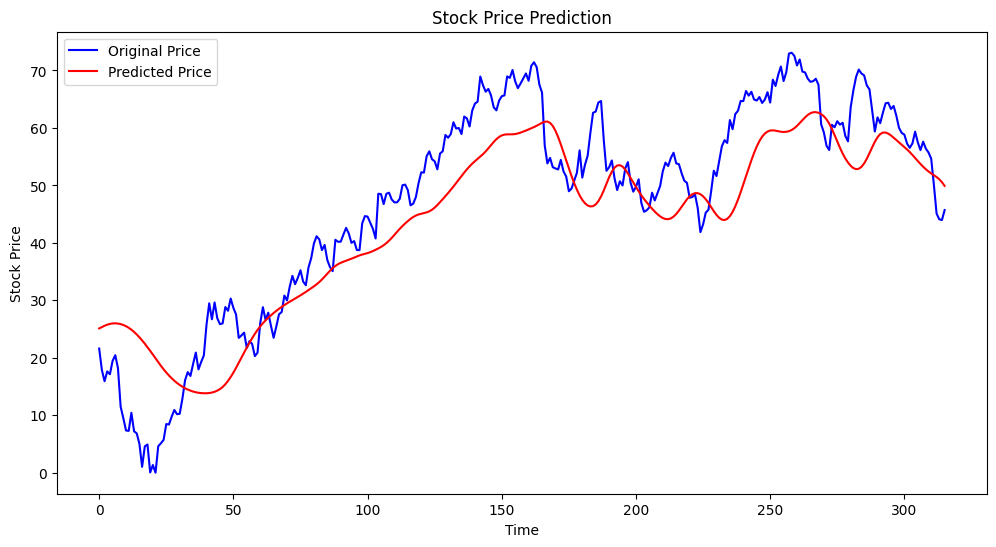

In [61]:
plt.figure(figsize=(12,6))
plt.plot(y_test, 'b', label='Original Price')
plt.plot(y_pred, 'r', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.legend()
plt.show()